In [ ]:
# for cloud use
!pip install pylatexenc qiskit==2.0.2 qiskit-aer
!wget https://raw.githubusercontent.com/Dpbm/qnqueens/refs/heads/main/utils.py

In [45]:
from typing import List
from math import sqrt, acos, pi
import os

from dotenv import load_dotenv

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.circuit.library import GroverOperator

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as IBMSampler

import matplotlib.pyplot as plt

from utils import get_diagonal_attacks, get_pos_mapping_qubit, Mapping

In [2]:
def get_W(n:int) -> QuantumCircuit:
    """
    params:
        n : int - the board side

    Get the W state for n qubits.
    """

    qc = QuantumCircuit(n, name="W(%d)"%(n))

    get_theta = lambda i : 2*acos(1/sqrt(i))

    base_value = n
    for qubit in range(0, n-1):
        if qubit == 0:
            qc.ry(get_theta(base_value), 0)
        else:
            qc.cry(get_theta(base_value), qubit-1, qubit)
        base_value -= 1

    for qubit in range(n-1, 0, -1):
        qc.cx(qubit-1,qubit)

    qc.x(0)

    return qc


In [3]:
def get_W_with_zero_at(qubits:int, zero_pos:List[int]):
    """
    params:
        qubits: int - the amount of qubits
        zero_pos: List[int] - the qubits which its value must be zero

    Apply a W state to some qubits with fixed zeros.
    """
    
    qc = QuantumCircuit(qubits, name="W_zero(%d)"%(len(zero_pos)))
    W_pos = list(set(list(range(qubits)))-{*zero_pos})
    qc.compose(get_W(qubits-len(zero_pos)), W_pos, inplace=True)

    return qc.to_gate()

# 3 Qubits Per Block Circuit

<IPython.core.display.Latex object>

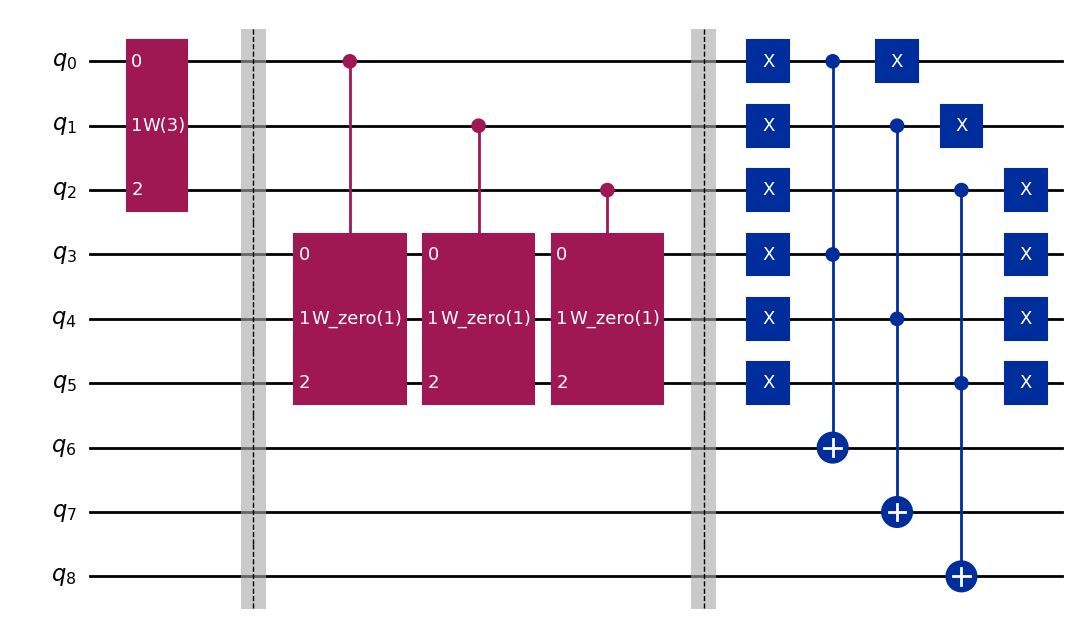

In [47]:
N = 3
total_qubits = N*N

state = QuantumCircuit(total_qubits, name="State")

state.append(get_W(N), list(range(N)))

state.barrier()

state.append(get_W_with_zero_at(N,[0]).control(1), [0, *list(range(N,2*N))])
state.append(get_W_with_zero_at(N,[1]).control(1), [1, *list(range(N,2*N))])
state.append(get_W_with_zero_at(N,[2]).control(1), [2, *list(range(N,2*N))])

state.barrier()


state.x([0,3])
state.ccx(0,3,6)
state.x([0,3])

state.x([1,4])
state.ccx(1,4,7)
state.x([1,4])

state.x([2,5])
state.ccx(2,5,8)
state.x([2,5])

display(Statevector(state).draw('latex'))
state.draw('mpl', filename="n=3-board-state.png")

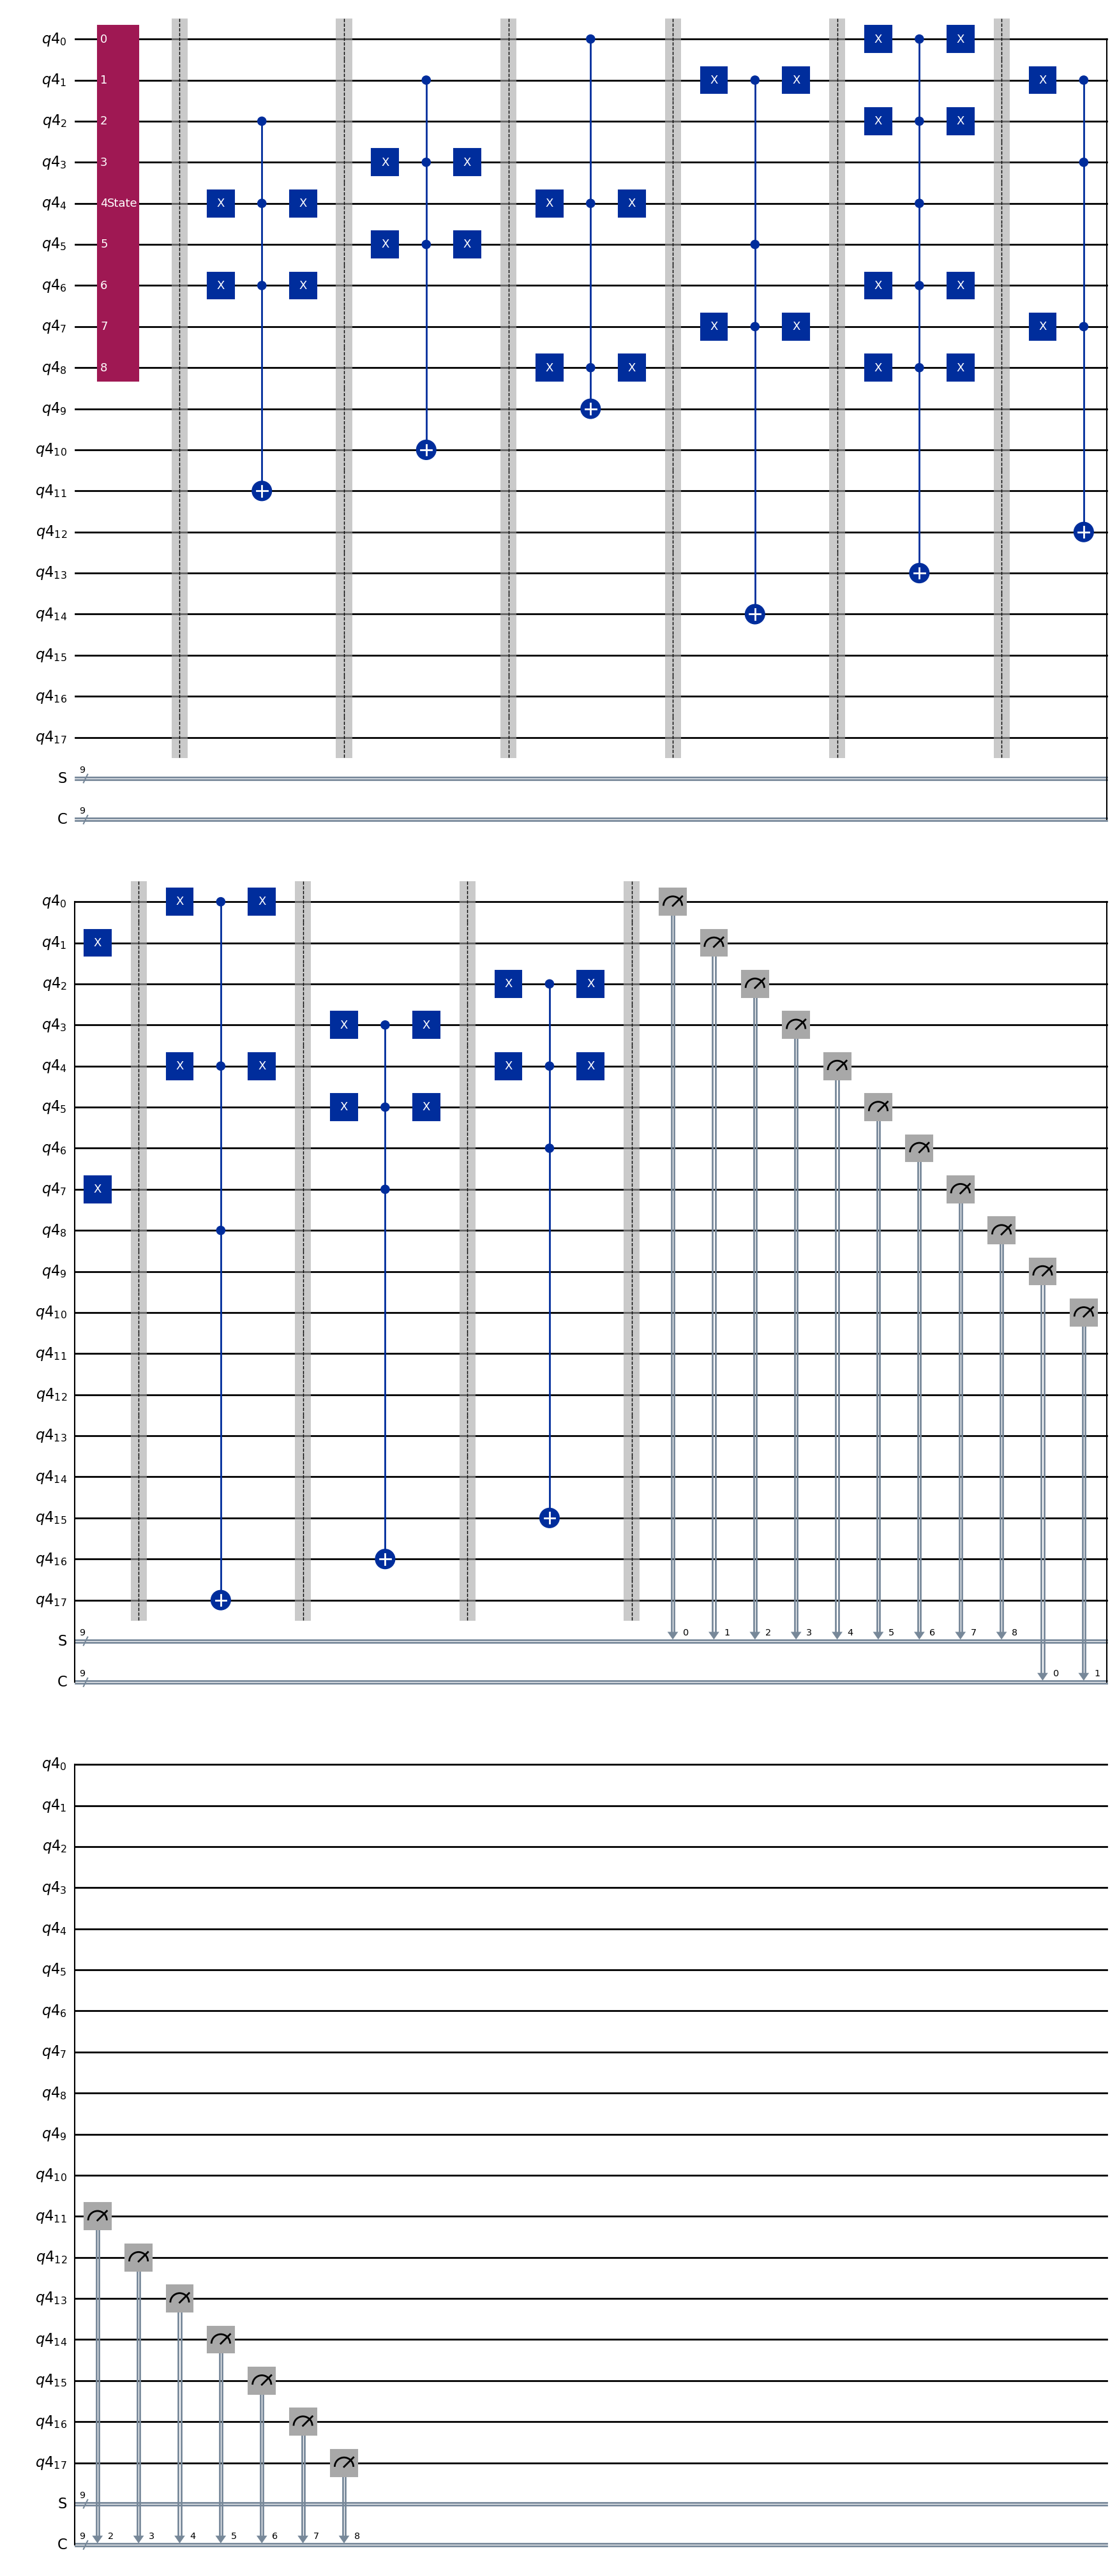

In [48]:
qubits = QuantumRegister(2*total_qubits)
state_reg = ClassicalRegister(total_qubits, name="S")
check_reg = ClassicalRegister(total_qubits, name="C")

qc = QuantumCircuit(qubits, state_reg, check_reg)
qc.append(state, list(range(total_qubits)))

mapping = get_pos_mapping_qubit(N)

for pos, qubit in mapping.items():
    attacks = get_diagonal_attacks(pos,N)

    x_qubits = [mapping[attack] for attack in attacks]

    qc.barrier()

    qc.x(x_qubits)
    qc.mcx([qubit, *x_qubits], qubit+total_qubits)
    qc.x(x_qubits)

qc.barrier()

qc.measure(list(range(total_qubits)), state_reg)
qc.measure(list(range(total_qubits,total_qubits*2)), check_reg)


qc.draw('mpl', filename="n=3-board-check.png")

In [10]:
sim = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=0, backend=sim)
sampler = SamplerV2()

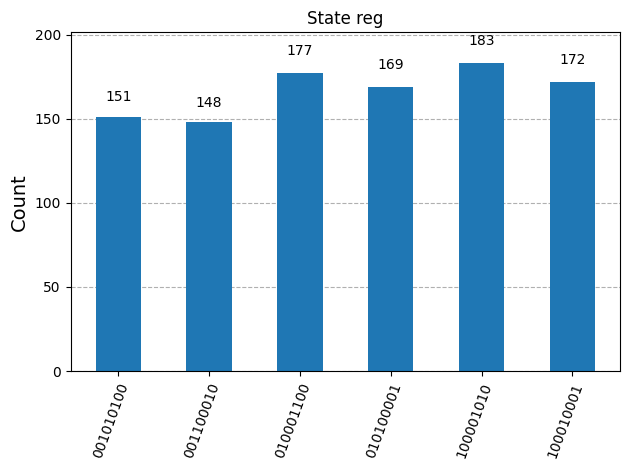

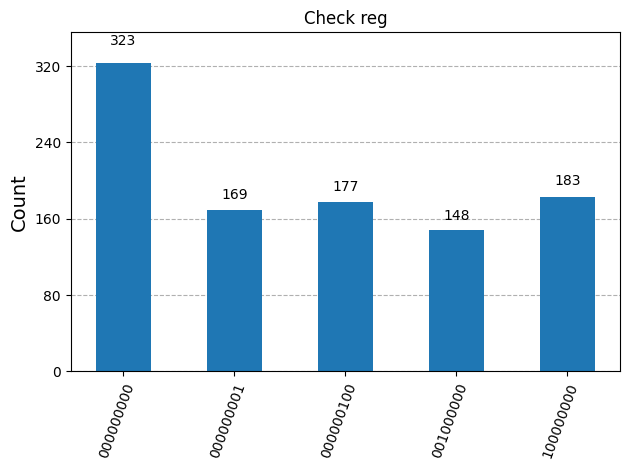

In [11]:
isa_qc = pm.run(qc)

result = sampler.run([isa_qc], shots=1000).result()

hist1 = plot_histogram(result[0].data.S.get_counts(), title="State reg")
hist2 = plot_histogram(result[0].data.C.get_counts(), title="Check reg")
hist1.savefig("n=3-board-state-reg-aer.png")
hist2.savefig("n=3-board-check-reg-aer.png")
display(hist1)
display(hist2)

In [12]:
load_dotenv()

True

In [13]:
service = QiskitRuntimeService(
    channel=os.getenv("QISKIT_IBM_CHANNEL"),
    token=os.getenv("QISKIT_IBM_TOKEN"),
    instance=os.getenv("QISKIT_IBM_INSTANCE")
)

In [14]:
backend = service.least_busy(operational=True)
backend_name = backend.name
backend_name

'ibm_torino'

In [15]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
sampler = IBMSampler(mode=backend)

In [16]:
isa_qc = pm.run(qc)

In [17]:
job = sampler.run([isa_qc], shots=1000)
job.job_id()

'd1la4lcuvp6s73c9u7kg'

In [18]:
job_data = service.job("d1la4lcuvp6s73c9u7kg")

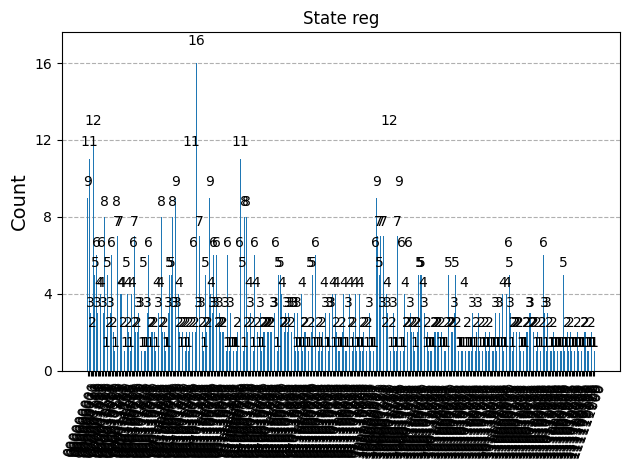

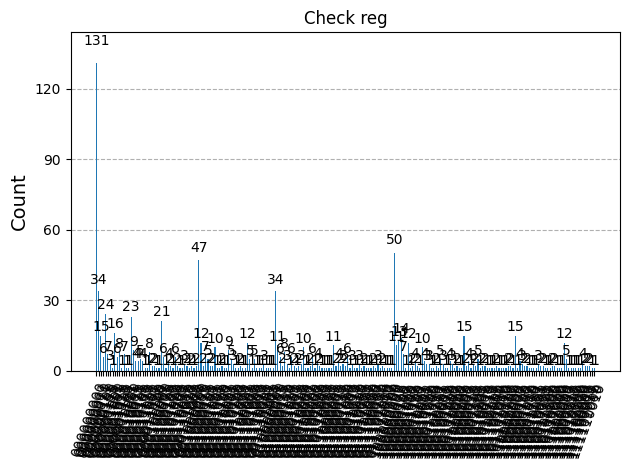

In [19]:
result = job_data.result()

hist1 = plot_histogram(result[0].data.S.get_counts(), title="State reg")
hist2 = plot_histogram(result[0].data.C.get_counts(), title="Check reg")
hist1.savefig("n=3-board-state-reg-%s.png"%(backend_name))
hist2.savefig("n=3-board-check-reg-%s.png"%(backend_name))
display(hist1)
display(hist2)

# 4 Qubits Block circuit

<IPython.core.display.Latex object>

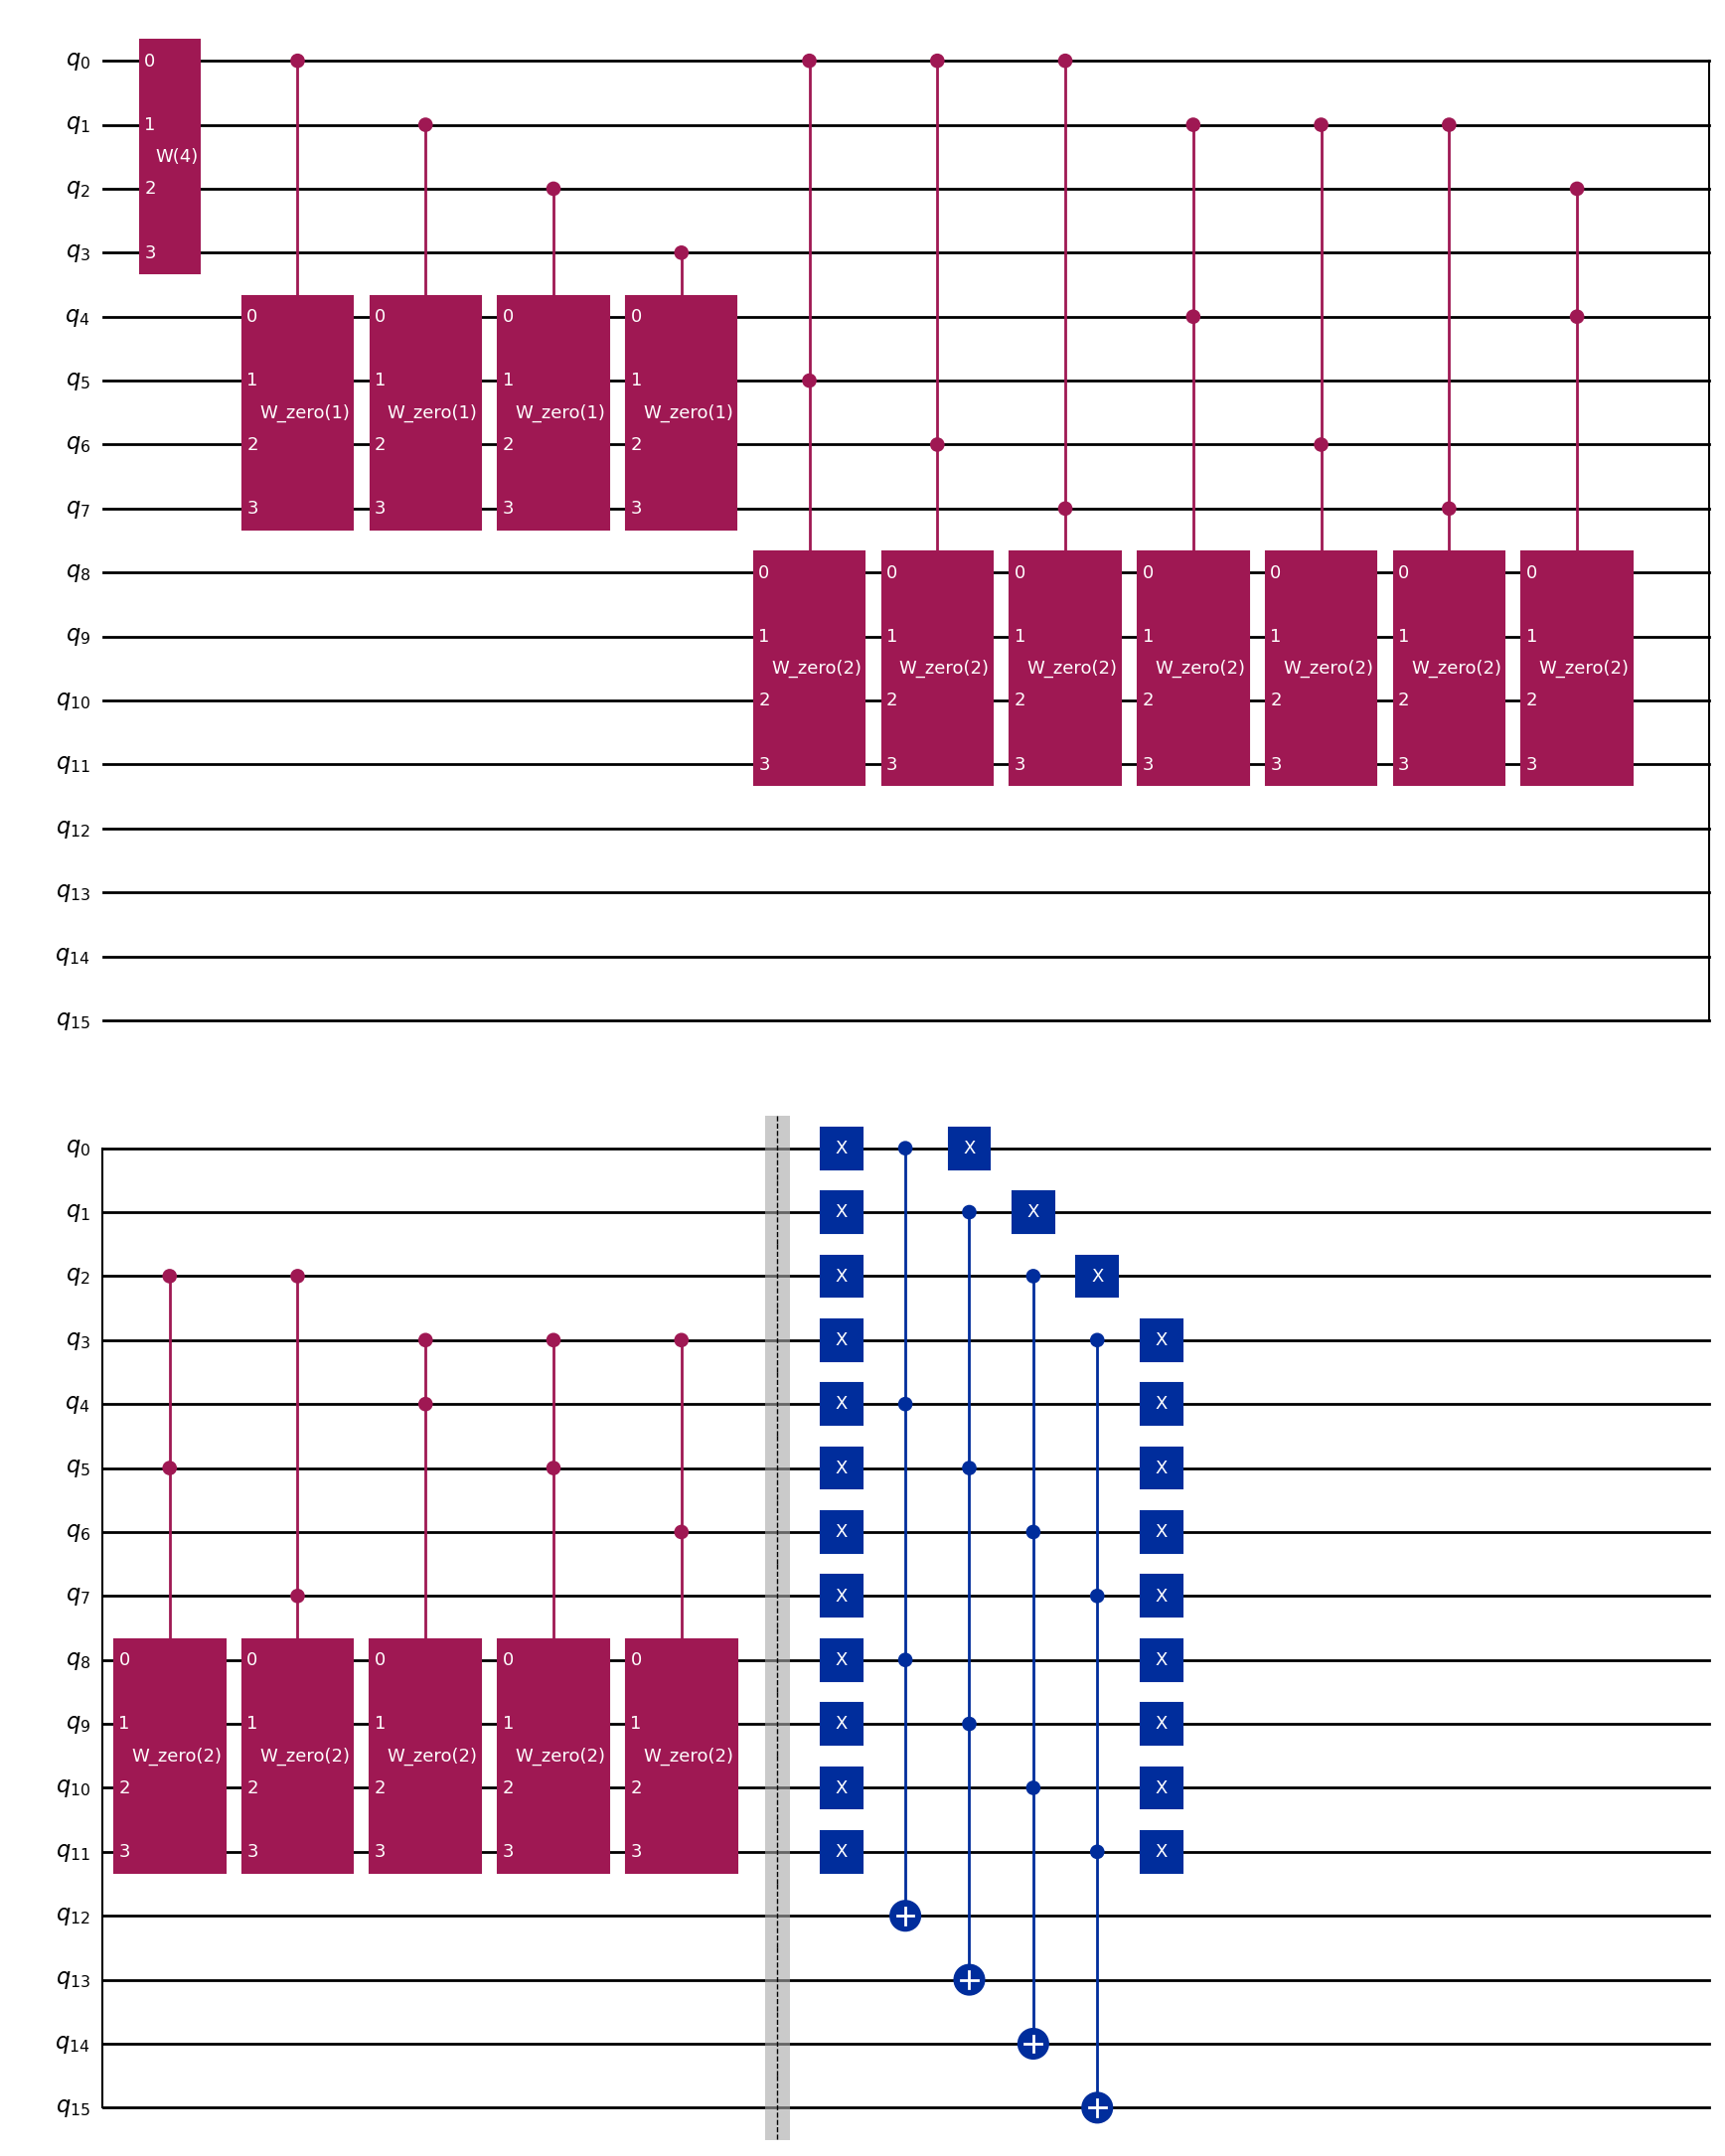

In [52]:
N = 4
total_qubits = N*N

state = QuantumCircuit(total_qubits, name="State")
state.append(get_W(N), list(range(N)))

state.append(get_W_with_zero_at(N,[0]).control(1), [0, *list(range(N,2*N))])
state.append(get_W_with_zero_at(N,[1]).control(1), [1, *list(range(N,2*N))])
state.append(get_W_with_zero_at(N,[2]).control(1), [2, *list(range(N,2*N))])
state.append(get_W_with_zero_at(N,[3]).control(1), [3, *list(range(N,2*N))])

state.append(get_W_with_zero_at(N,[0,1]).control(2), [0, 5, *list(range(2*N,3*N))])
state.append(get_W_with_zero_at(N,[0,2]).control(2), [0, 6, *list(range(2*N,3*N))])
state.append(get_W_with_zero_at(N,[0,3]).control(2), [0, 7, *list(range(2*N,3*N))])

state.append(get_W_with_zero_at(N,[1,0]).control(2), [1, 4, *list(range(2*N,3*N))])
state.append(get_W_with_zero_at(N,[1,2]).control(2), [1, 6, *list(range(2*N,3*N))])
state.append(get_W_with_zero_at(N,[1,3]).control(2), [1, 7, *list(range(2*N,3*N))])

state.append(get_W_with_zero_at(N,[2,0]).control(2), [2, 4, *list(range(2*N,3*N))])
state.append(get_W_with_zero_at(N,[2,1]).control(2), [2, 5, *list(range(2*N,3*N))])
state.append(get_W_with_zero_at(N,[2,3]).control(2), [2, 7, *list(range(2*N,3*N))])

state.append(get_W_with_zero_at(N,[3,0]).control(2), [3, 4, *list(range(2*N,3*N))])
state.append(get_W_with_zero_at(N,[3,1]).control(2), [3, 5, *list(range(2*N,3*N))])
state.append(get_W_with_zero_at(N,[3,2]).control(2), [3, 6, *list(range(2*N,3*N))])

state.barrier()

state.x([0,4,8])
state.mcx([0,4,8],12)
state.x([0,4,8])

state.x([1,5,9])
state.mcx([1,5,9],13)
state.x([1,5,9])

state.x([2,6,10])
state.mcx([2,6,10],14)
state.x([2,6,10])

state.x([3,7,11])
state.mcx([3,7,11],15)
state.x([3,7,11])

display(Statevector(state).draw('latex'))
state.draw('mpl', filename="n=4-board-state.png")

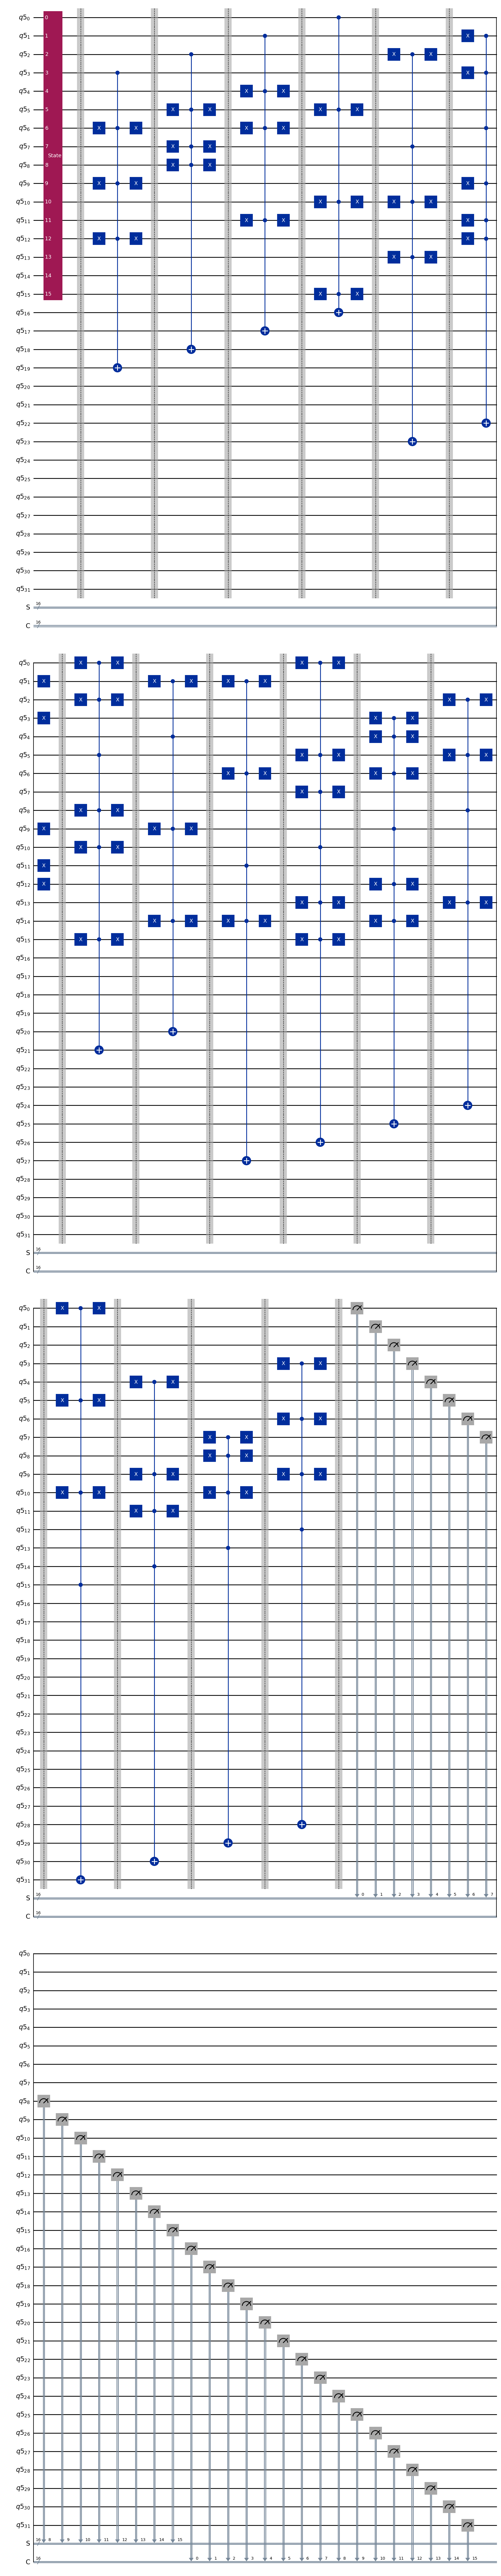

In [53]:
qubits = QuantumRegister(2*total_qubits)
state_reg = ClassicalRegister(total_qubits, name="S")
check_reg = ClassicalRegister(total_qubits, name="C")
qc = QuantumCircuit(qubits, state_reg, check_reg)

qc.append(state, list(range(total_qubits)))

mapping = get_pos_mapping_qubit(N)

for pos, qubit in mapping.items():
    attacks = get_diagonal_attacks(pos,N)

    x_qubits = [mapping[attack] for attack in attacks]
    qc.barrier()

    qc.x(x_qubits)
    qc.mcx([qubit, *x_qubits], qubit+total_qubits)
    qc.x(x_qubits)

qc.barrier()
qc.measure(list(range(total_qubits)), state_reg)
qc.measure(list(range(total_qubits,total_qubits*2)), check_reg)

qc.draw('mpl', filename="n=4-board-check.png")

In [38]:
isa_qc = pm.run(qc)

In [39]:
job = sampler.run([isa_qc], shots=1000)
job.job_id()

'd1la867a572c7397537g'

In [40]:
job_data = service.job('d1la867a572c7397537g')

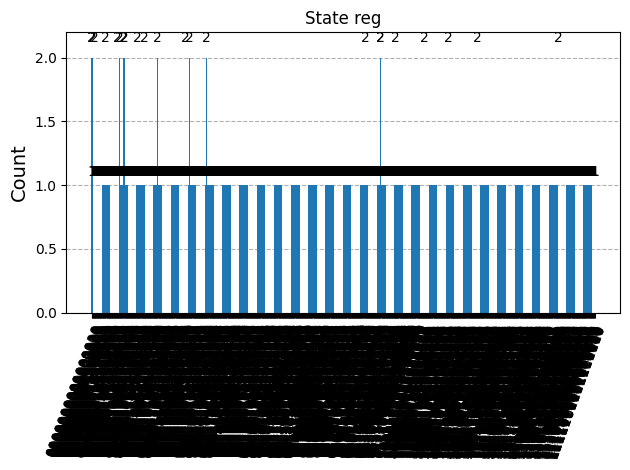

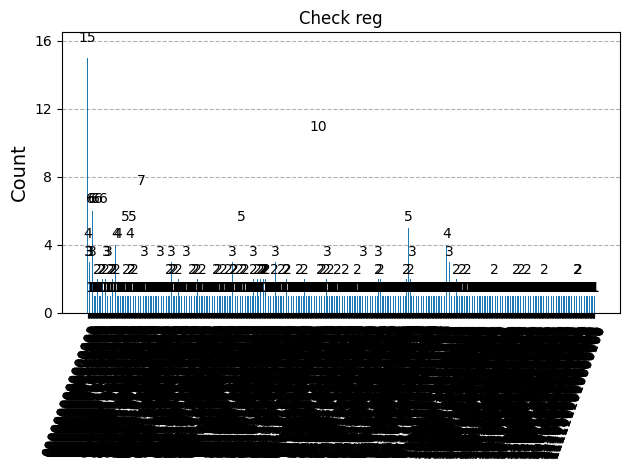

In [41]:
result = job_data.result()

hist1 = plot_histogram(result[0].data.S.get_counts(), title="State reg")
hist2 = plot_histogram(result[0].data.C.get_counts(), title="Check reg")
hist1.savefig("n=4-board-state-reg-%s.png"%(backend_name))
hist2.savefig("n=4-board-check-reg-%s.png"%(backend_name))
display(hist1)
display(hist2)

In [43]:
def show_board(bit_string:str, n:int):
    """
    params:
        bit_string:str
        n:int - board side

    plot the solution bitstring as a board.
    """

    bit_string = bit_string[::-1]

    matrix = []

    for i in range(n):
        row = list(map(int, list(bit_string[i*n:(i*n)+n][::-1])))
        matrix.append(row)
        

    plt.pcolormesh(matrix,edgecolors="k",linewidth=2)
    plt.title("Bit string=%s"%(bit_string))
    plt.axis('off')
    plt.show()

In [49]:
def valid_check_bit_string(bit_string:str, n:int) -> bool:
    """
    params:
        bit_string:str
        n:int - board side

    Check if the check register is valid.
    """

    for i in range(n):
        if(bit_string[i*n:(i*n)+n].count('1') != 1):
            return False

    return True

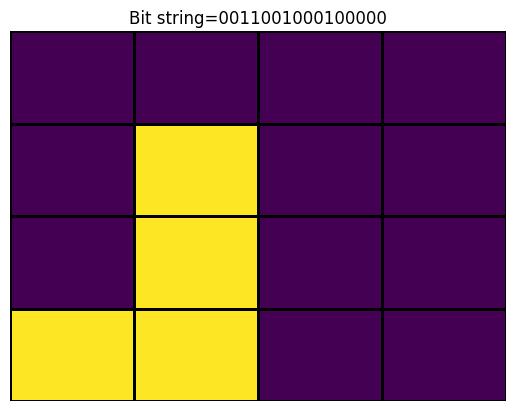

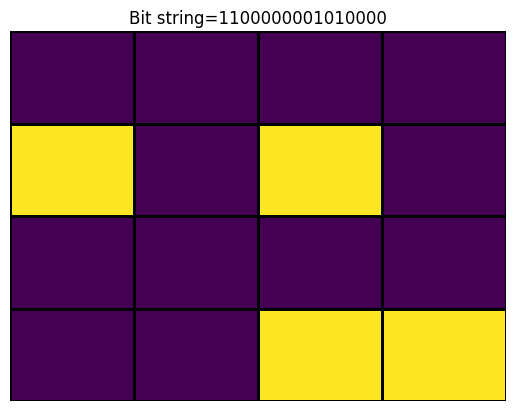

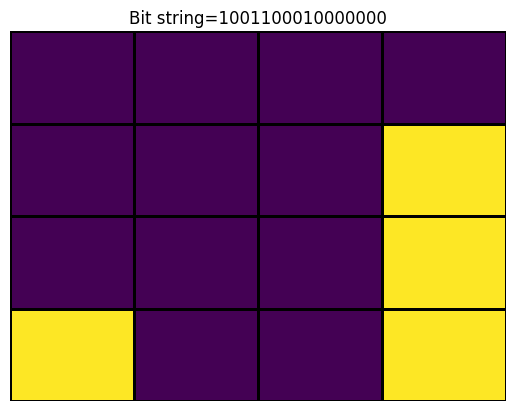

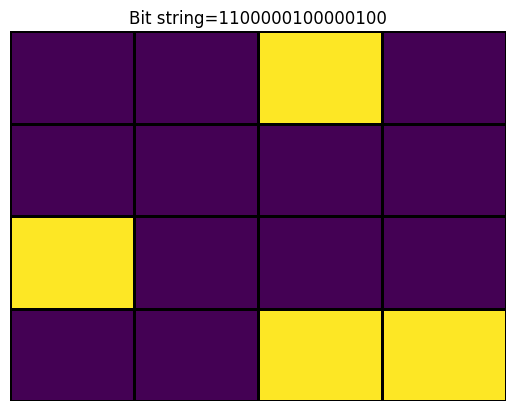

In [55]:
for k,v in result[0].join_data().get_counts().items():
    first_part = k[:total_qubits]
    second_part = k[total_qubits:]

    if(valid_check_bit_string(first_part, N) and second_part.count('1') == N):
        show_board(second_part, N)
